In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import boxcox_normmax, boxcox, chi2_contingency
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                           classification_report, roc_auc_score, accuracy_score,
                           roc_curve, auc, confusion_matrix)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Data types:\n{df.dtypes}")

Dataset shape: (114000, 21)
Columns: ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']
Data types:
Unnamed: 0            int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object


In [ ]:
pitch_class = {
    -1: 'No key', 0: 'C', 1: 'C♯/D♭', 2: 'D', 3: 'D♯/E♭', 4: 'E', 5: 'F',
    6: 'F♯/G♭', 7: 'G', 8: 'G♯/A♭', 9: 'A', 10: 'A♯/B♭', 11: 'B'
}

time_signatures = {3: "3/4", 4: "4/4", 5: "5/4", 6: "6/4", 7: "7/4"}
modes = {1: "Major", 0: "Minor"}

In [ ]:
try:
    df["duration_mins"] = df["duration_ms"] / 60000
    df["key"] = df["key"].map(pitch_class)
    df = df.drop(["Unnamed: 0", "duration_ms"], axis=1)
    df["time_signature"] = df["time_signature"].map(time_signatures)
    df["mode"] = df["mode"].map(modes)
    print("Data preprocessing completed successfully")
except Exception as e:
    print(f"Preprocessing already done or error: {e}")


Data preprocessing completed successfully


In [ ]:
df_songs = df.loc[df["speechiness"] < 0.66].copy()
df_songs["collaboration"] = df_songs["artists"].str.contains(";", na=False)
df_songs_tree = df_songs.copy()

In [ ]:
df_songs = df_songs.drop_duplicates(subset="track_name")
df_songs = df_songs.dropna(subset=["artists", "album_name"])
df_songs = df_songs.drop_duplicates()


In [ ]:
df_songs["time_signature"] = df_songs["time_signature"].replace([None, "", "nan", "NaN"], np.nan)
df_songs["time_signature"] = df_songs["time_signature"].fillna("Unknown")

print(f"Final dataset shape: {df_songs.shape}")
print(f"Missing values:\n{df_songs.isnull().sum()}")

Final dataset shape: (72800, 21)
Missing values:
track_id            0
artists             0
album_name          0
track_name          0
popularity          0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
duration_mins       0
collaboration       0
dtype: int64


Numerical columns: ['popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_mins']


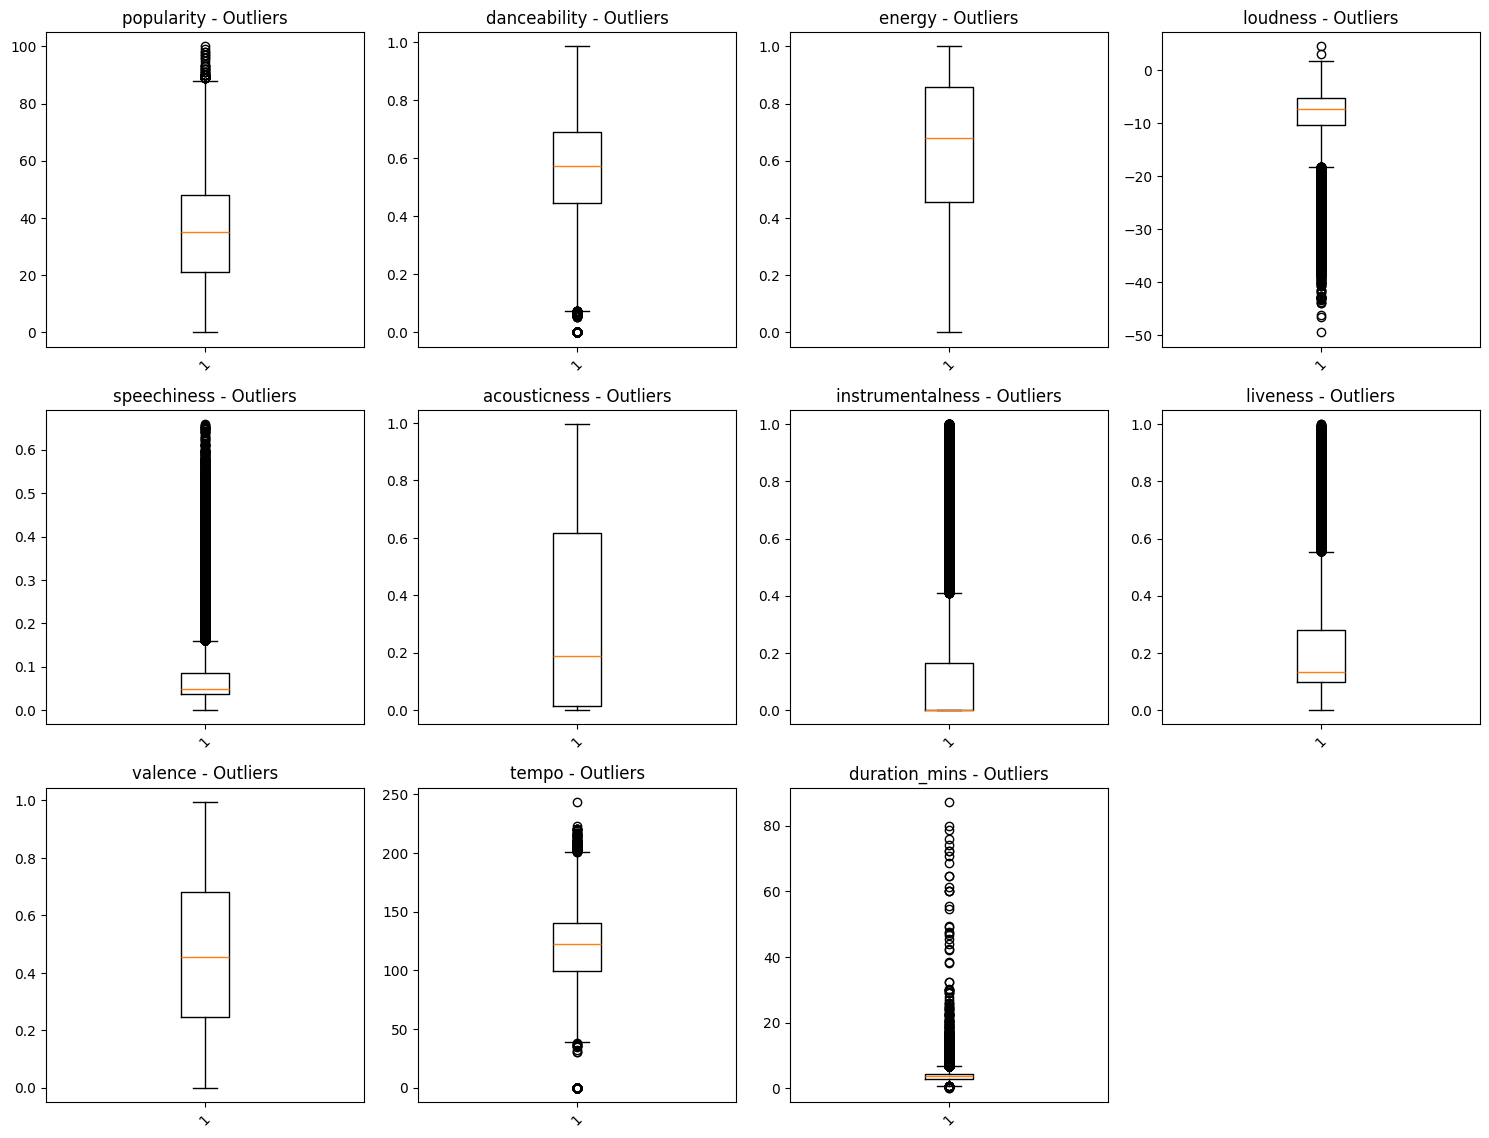

In [ ]:
num_cols = [col for col in df_songs.columns if df_songs[col].dtype in ["int64", "float64"]]
print(f"Numerical columns: {num_cols}")
# Outlier detection with boxplots
grid_size = math.ceil(np.sqrt(len(num_cols)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    if i < len(axes):
        axes[i].boxplot(df_songs[col])
        axes[i].set_title(f'{col} - Outliers')
        axes[i].tick_params(axis='x', rotation=45)
for i in range(len(num_cols), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()



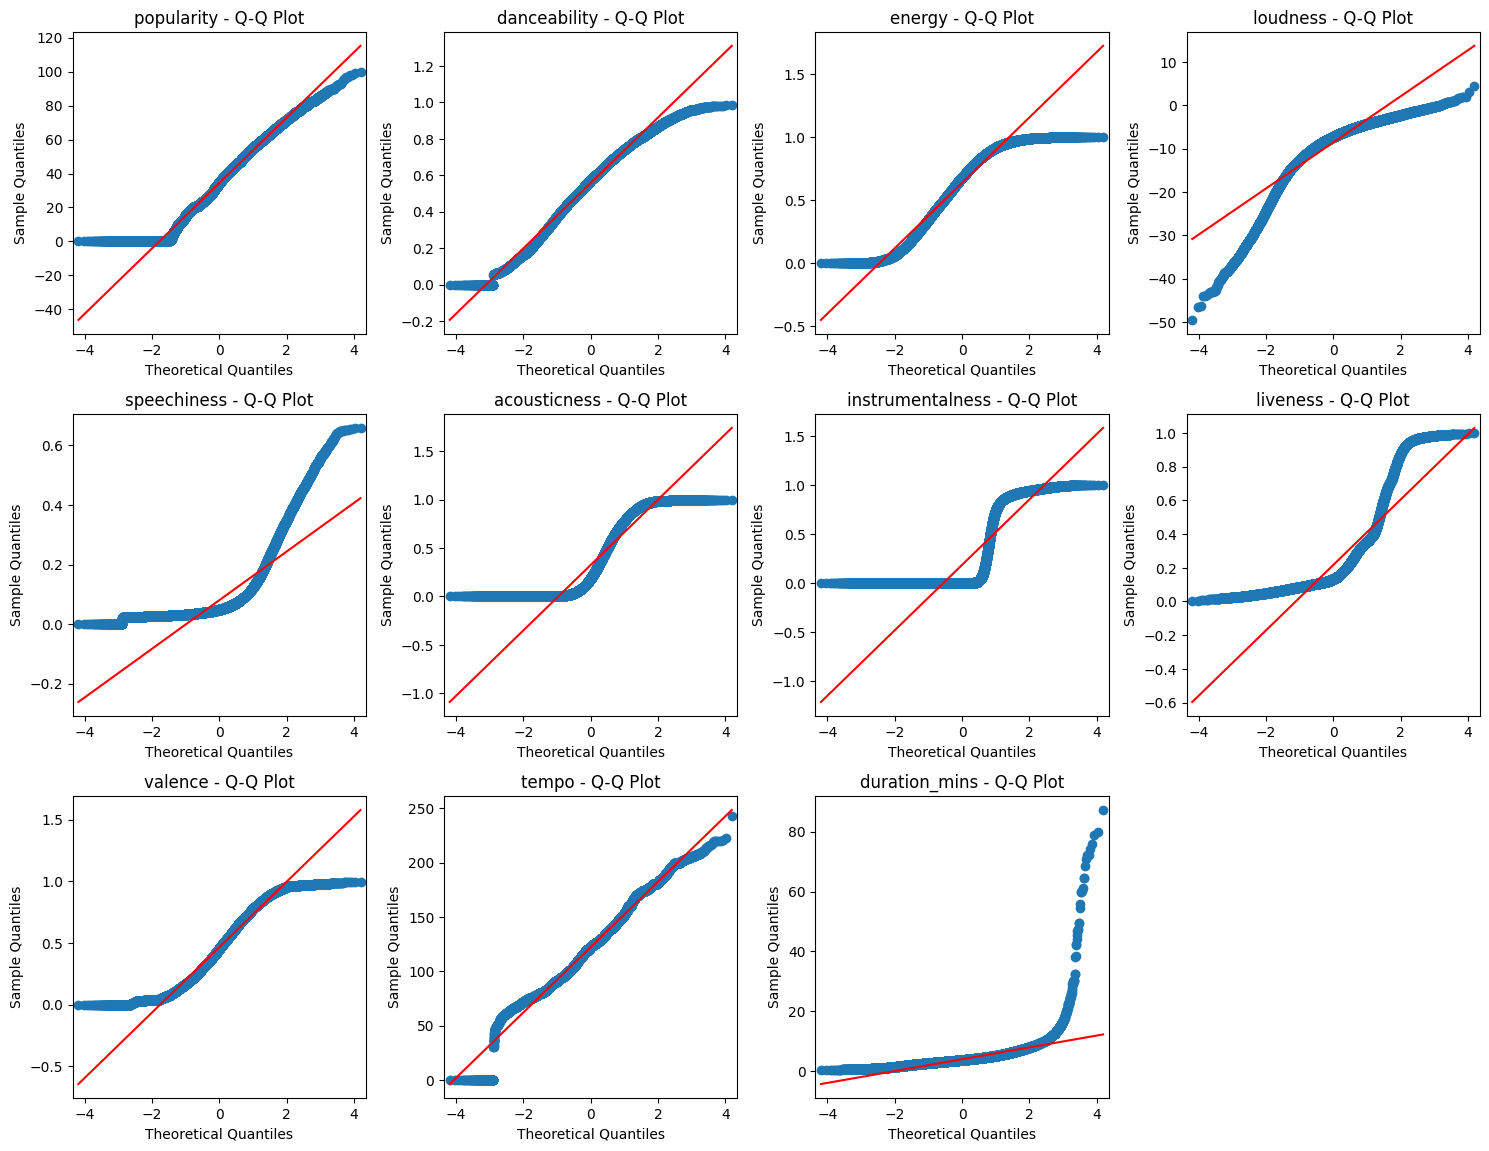

In [ ]:
# Q-Q plots for normality assessment
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    if i < len(axes):
        qqplot(df_songs[col], line='s', ax=axes[i])
        axes[i].set_title(f'{col} - Q-Q Plot')

for i in range(len(num_cols), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# Box-Cox transformation preparation
df_songs_shifted = df_songs.copy()
boxcox_lambdas = {}

for col in num_cols:
    shift = abs(df_songs_shifted[col].min()) + 0.00001 if df_songs_shifted[col].min() <= 0 else 0
    df_songs_shifted[col] += shift

    # Calculate optimal lambda
    lambda_val = boxcox_normmax(df_songs_shifted[col])
    boxcox_lambdas[col] = lambda_val
    print(f"Box-Cox lambda for {col}: {lambda_val:.4f}")

Box-Cox lambda for popularity: 0.9637
Box-Cox lambda for danceability: 1.3897
Box-Cox lambda for energy: 1.4764
Box-Cox lambda for loudness: 5.5882
Box-Cox lambda for speechiness: 0.1650
Box-Cox lambda for acousticness: 0.2977
Box-Cox lambda for instrumentalness: -0.0960
Box-Cox lambda for liveness: -0.0747
Box-Cox lambda for valence: 0.7311
Box-Cox lambda for tempo: 0.9597
Box-Cox lambda for duration_mins: 0.0984


# **Linear Regression Analysis:**
 Album Hit Effect on Other Songs

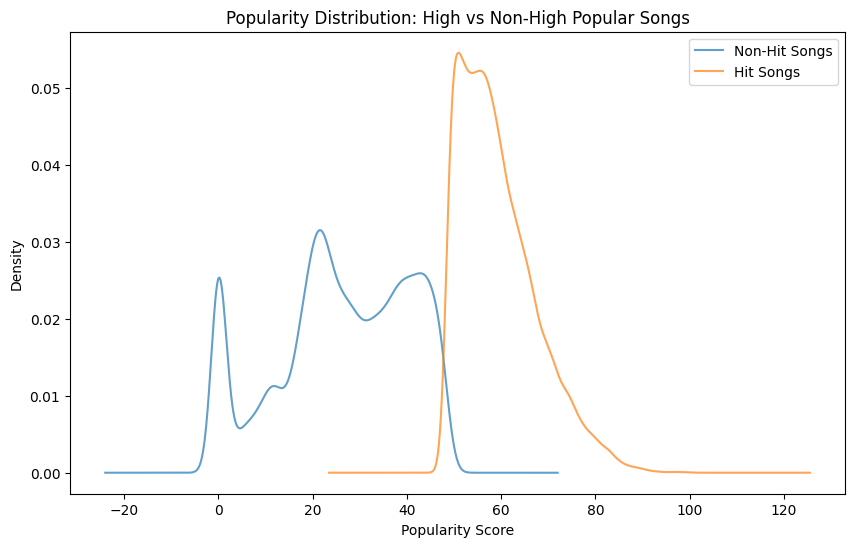

In [ ]:
df_songs["high_pop"] = df_songs["popularity"] > df_songs["popularity"].quantile(0.75)

# Visualize popularity distribution
plt.figure(figsize=(10, 6))
df_songs.groupby("high_pop")["popularity"].plot(kind="density", legend=True, alpha=0.7)
plt.title("Popularity Distribution: High vs Non-High Popular Songs")
plt.xlabel("Popularity Score")
plt.ylabel("Density")
plt.legend(["Non-Hit Songs", "Hit Songs"])
plt.show()

Albums analyzed: 1096
Album summary statistics:
       mean_non_hit_popularity  hit_popularity   song_count
count              1096.000000     1096.000000  1096.000000
mean                 37.925798       57.572993     5.734489
std                  10.210583        7.402712     4.845347
min                   0.000000       49.000000     3.000000
25%                  32.333333       52.000000     3.000000
50%                  42.500000       56.000000     4.000000
75%                  45.333333       62.000000     7.000000
max                  48.000000       85.000000    90.000000


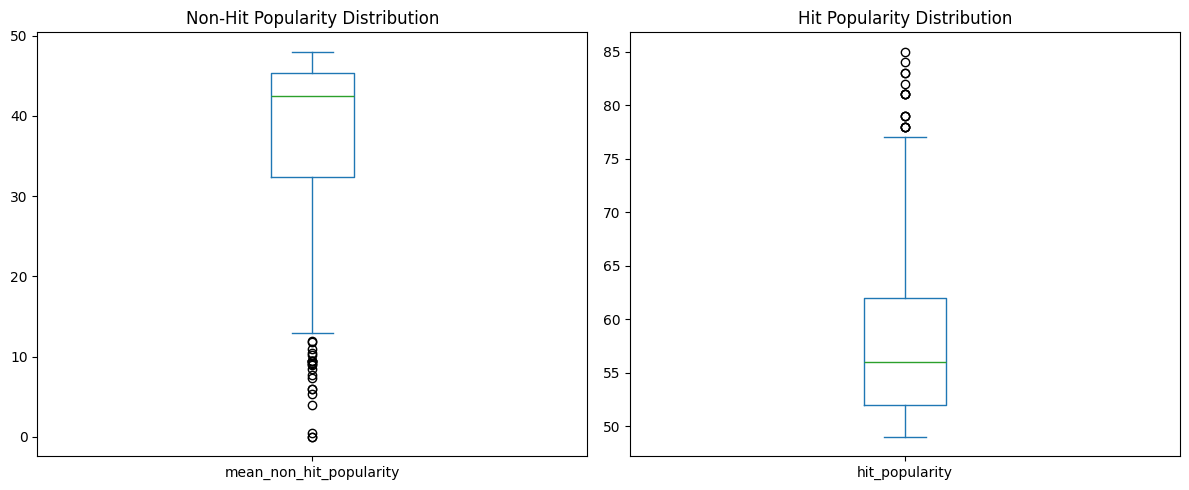

In [ ]:
non_hit_mean = df_songs[~df_songs['high_pop']].groupby('album_name')['popularity'].mean().reset_index(name='mean_non_hit_popularity')
hit_popularity = df_songs[df_songs['high_pop']].groupby('album_name')['popularity'].max().reset_index(name='hit_popularity')
song_count = df_songs.groupby('album_name')['popularity'].count().reset_index(name='song_count')

# Merging album statistics
album_summary = pd.merge(non_hit_mean, hit_popularity, on='album_name', how='outer')
album_summary = pd.merge(album_summary, song_count, on='album_name', how='outer')

# Missing values and filter albums with sufficient data
album_summary = album_summary.dropna()
album_summary = album_summary[album_summary['song_count'] >= 3]  # Albums with at least 3 songs

print(f"Albums analyzed: {len(album_summary)}")
print(f"Album summary statistics:\n{album_summary.describe()}")

# Box plots for album-level analysis
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
album_summary["mean_non_hit_popularity"].plot(kind='box', ax=axes[0], title="Non-Hit Popularity Distribution")
album_summary["hit_popularity"].plot(kind='box', ax=axes[1], title="Hit Popularity Distribution")
plt.tight_layout()
plt.show()

In [ ]:
X = album_summary[['hit_popularity']]
y = album_summary['mean_non_hit_popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_const = sm.add_constant(X_train)

In [ ]:
ols_model = sm.OLS(y_train, X_train_const).fit()
print("Linear Regression Model Summary:")
print(ols_model.summary())

Linear Regression Model Summary:
                               OLS Regression Results                              
Dep. Variable:     mean_non_hit_popularity   R-squared:                       0.004
Model:                                 OLS   Adj. R-squared:                  0.003
Method:                      Least Squares   F-statistic:                     3.221
Date:                     Fri, 11 Jul 2025   Prob (F-statistic):             0.0731
Time:                             13:44:11   Log-Likelihood:                -3268.2
No. Observations:                      876   AIC:                             6540.
Df Residuals:                          874   BIC:                             6550.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------


Model Performance:
Train R²: 0.0037
Test R²: 0.0109
Train RMSE: 10.0931
Test RMSE: 10.5022


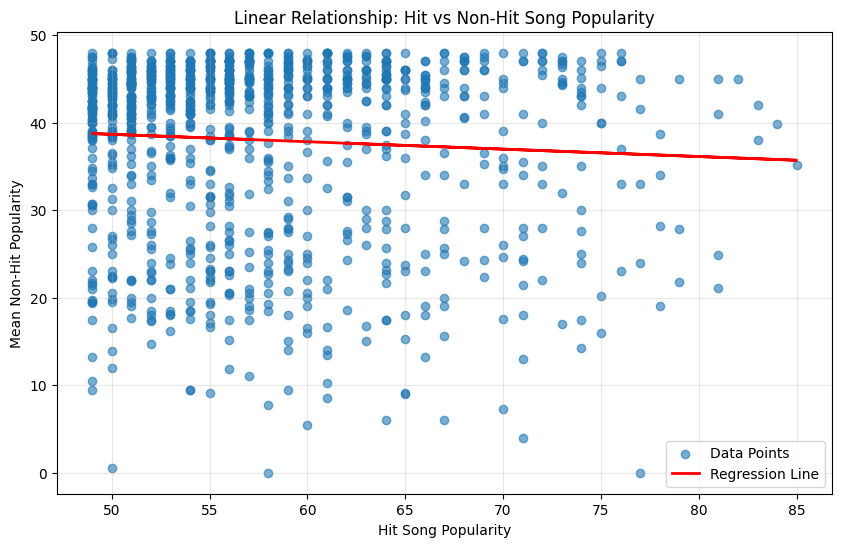

In [ ]:
y_train_pred = ols_model.predict(X_train_const)
X_test_const = sm.add_constant(X_test)
y_test_pred = ols_model.predict(X_test_const)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\nModel Performance:")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.6, label='Data Points')
plt.plot(X_train, y_train_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Hit Song Popularity')
plt.ylabel('Mean Non-Hit Popularity')
plt.title('Linear Relationship: Hit vs Non-Hit Song Popularity')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# LOG TRANSFORMATION MODEL
X_log = np.log(album_summary[['hit_popularity']])
X_log_train, X_log_test, y_train, y_test = train_test_split(X_log, y, test_size=0.2, random_state=42)
X_log_train_const = sm.add_constant(X_log_train)

log_ols_model = sm.OLS(y_train, X_log_train_const).fit()
print("\nLog-Transformed Model Summary:")
print(log_ols_model.summary())


Log-Transformed Model Summary:
                               OLS Regression Results                              
Dep. Variable:     mean_non_hit_popularity   R-squared:                       0.003
Model:                                 OLS   Adj. R-squared:                  0.002
Method:                      Least Squares   F-statistic:                     2.917
Date:                     Fri, 11 Jul 2025   Prob (F-statistic):             0.0880
Time:                             13:44:12   Log-Likelihood:                -3268.3
No. Observations:                      876   AIC:                             6541.
Df Residuals:                          874   BIC:                             6550.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [ ]:
# BOX-COX TRANSFORMATION
album_summary_bc = album_summary.copy()
album_summary_bc['mean_non_hit_popularity'] = album_summary_bc['mean_non_hit_popularity'].clip(lower=1e-3)
box_cox_lambda = boxcox_normmax(album_summary_bc['mean_non_hit_popularity'])
album_summary_bc['mean_non_hit_popularity_boxcox'] = boxcox(album_summary_bc['mean_non_hit_popularity'], lmbda=box_cox_lambda)

# Box-Cox model
X_bc = album_summary_bc[['hit_popularity']]
y_bc = album_summary_bc['mean_non_hit_popularity_boxcox']
X_bc_train, X_bc_test, y_bc_train, y_bc_test = train_test_split(X_bc, y_bc, test_size=0.2, random_state=42)
X_bc_train_const = sm.add_constant(X_bc_train)

ols_model_bc = sm.OLS(y_bc_train, X_bc_train_const).fit()
print(f"\nBox-Cox Model (lambda={box_cox_lambda:.4f}):")
print(ols_model_bc.summary())



Box-Cox Model (lambda=6.1810):
                                  OLS Regression Results                                  
Dep. Variable:     mean_non_hit_popularity_boxcox   R-squared:                       0.000
Model:                                        OLS   Adj. R-squared:                 -0.001
Method:                             Least Squares   F-statistic:                   0.06460
Date:                            Fri, 11 Jul 2025   Prob (F-statistic):              0.799
Time:                                    13:44:12   Log-Likelihood:                -19611.
No. Observations:                             876   AIC:                         3.923e+04
Df Residuals:                                 874   BIC:                         3.924e+04
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
                     coef    std err          t      P>|t|

In [ ]:
# Heteroskedasticity test
residuals = y_bc_train - ols_model_bc.predict(X_bc_train_const)
_, bp_pval, _, _ = het_breuschpagan(residuals, X_bc_train_const)
print(f"Breusch-Pagan test p-value: {bp_pval:.4f}")


Breusch-Pagan test p-value: 0.0000


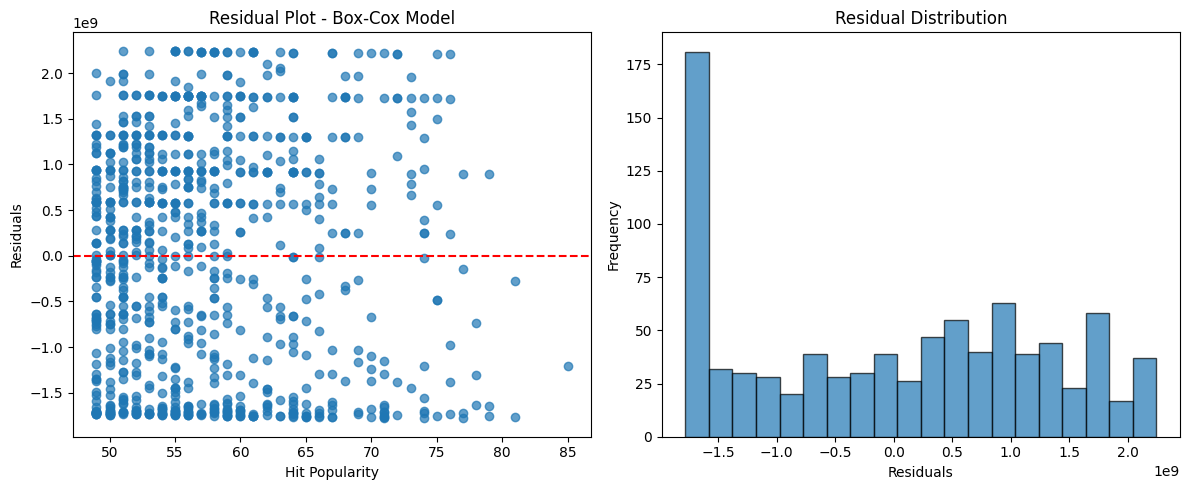

In [ ]:
# Residual analysis
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_bc_train['hit_popularity'], residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Hit Popularity")
plt.ylabel("Residuals")
plt.title("Residual Plot - Box-Cox Model")

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.tight_layout()
plt.show()

In [ ]:
# WEIGHTED LEAST SQUARES (WLS) for heteroskedasticity
weights = 1 / np.square(ols_model.resid + 1e-6)  # Add small constant to avoid division by zero
wls_model = sm.WLS(y_train, X_train_const, weights=weights).fit()
print("\nWeighted Least Squares Model:")
print(wls_model.summary())

# WLS predictions and evaluation
y_test_pred_wls = wls_model.predict(X_test_const)
wls_r2 = r2_score(y_test, y_test_pred_wls)
wls_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_wls))

print(f"\nWLS Model Performance:")
print(f"Test R²: {wls_r2:.4f}")
print(f"Test RMSE: {wls_rmse:.4f}")


Weighted Least Squares Model:
                               WLS Regression Results                              
Dep. Variable:     mean_non_hit_popularity   R-squared:                       0.701
Model:                                 WLS   Adj. R-squared:                  0.701
Method:                      Least Squares   F-statistic:                     2048.
Date:                     Fri, 11 Jul 2025   Prob (F-statistic):          2.87e-231
Time:                             13:44:14   Log-Likelihood:                -2781.9
No. Observations:                      876   AIC:                             5568.
Df Residuals:                          874   BIC:                             5577.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

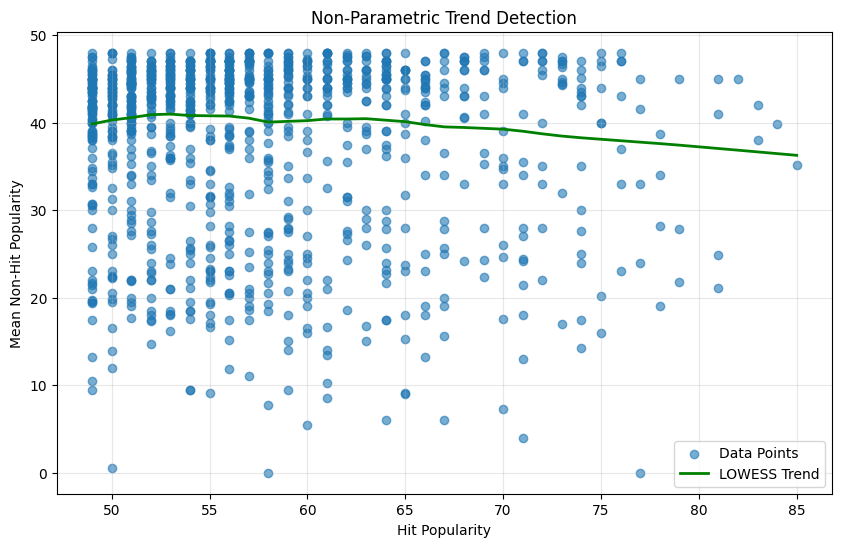

In [ ]:
# Non-parametric trend analysis (LOWESS)
lowess_result = sm.nonparametric.lowess(y, X['hit_popularity'], frac=0.3)
plt.figure(figsize=(10, 6))
plt.scatter(X['hit_popularity'], y, alpha=0.6, label='Data Points')
plt.plot(lowess_result[:, 0], lowess_result[:, 1], color='green', linewidth=2, label='LOWESS Trend')
plt.xlabel("Hit Popularity")
plt.ylabel("Mean Non-Hit Popularity")
plt.title("Non-Parametric Trend Detection")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# **LOGISTIC REGRESSION**
COLLABORATION PREDICTION

In [ ]:
collab_pct = (df_songs["collaboration"].sum() / len(df_songs)) * 100
print(f"Collaboration percentage: {collab_pct:.2f}%")

Collaboration percentage: 25.24%


In [ ]:
df_songs_collab = df_songs[df_songs["collaboration"] == True]
df_songs_solo = df_songs[df_songs["collaboration"] == False]
print("\nStatistical comparison between collaborative and solo songs:")
for col in num_cols:
    if col in df_songs.columns:
        collab_mean = df_songs_collab[col].mean()
        solo_mean = df_songs_solo[col].mean()
        mean_diff = collab_mean - solo_mean
        t_stat, p_val = stats.ttest_ind(df_songs_collab[col], df_songs_solo[col])
        print(f"{col}: Difference = {mean_diff:.4f}, p-value = {p_val:.4f}")


Statistical comparison between collaborative and solo songs:
popularity: Difference = 1.8251, p-value = 0.0000
danceability: Difference = 0.0412, p-value = 0.0000
energy: Difference = -0.0162, p-value = 0.0000
loudness: Difference = 0.0135, p-value = 0.7662
speechiness: Difference = 0.0157, p-value = 0.0000
acousticness: Difference = 0.0111, p-value = 0.0001
instrumentalness: Difference = -0.0299, p-value = 0.0000
liveness: Difference = -0.0088, p-value = 0.0000
valence: Difference = -0.0236, p-value = 0.0000
tempo: Difference = -1.2309, p-value = 0.0000
duration_mins: Difference = 0.0955, p-value = 0.0000


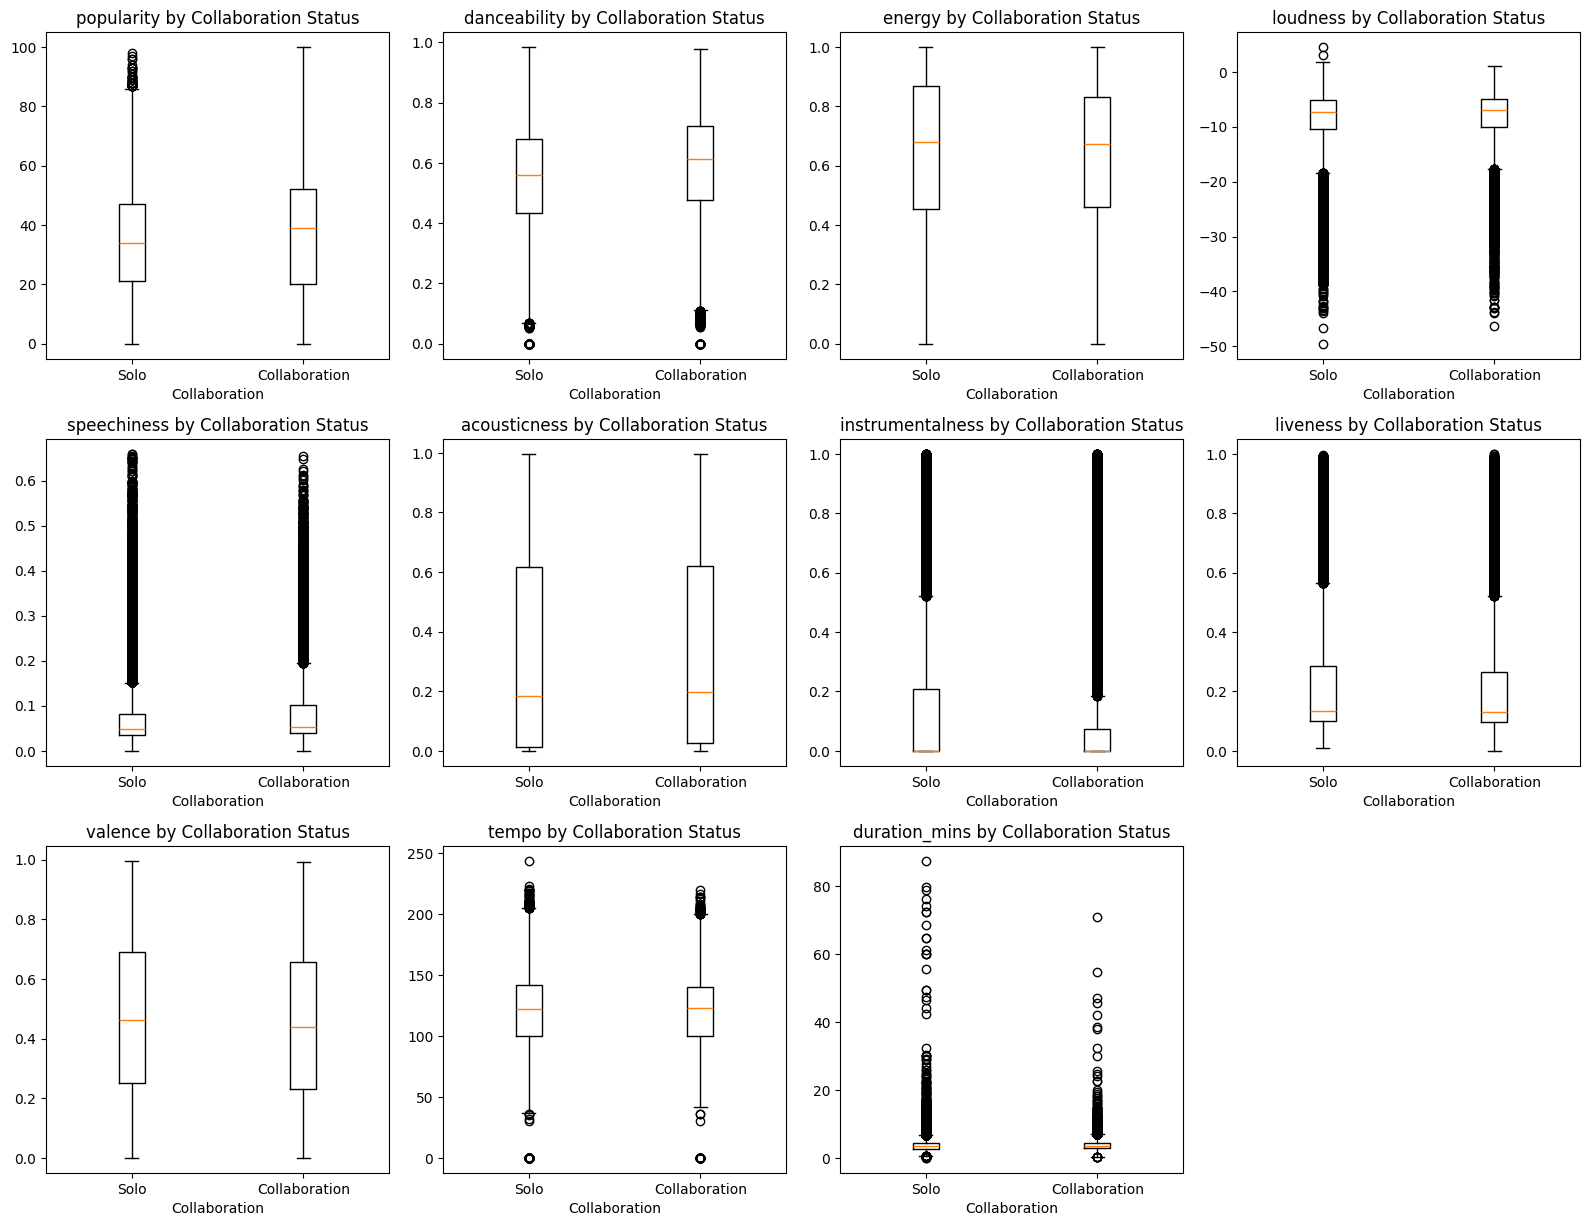

In [ ]:
fig, axes = plt.subplots(grid_size, grid_size, figsize=(16, 16))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    if i < len(axes) and col in df_songs.columns:
        data = [df_songs[df_songs["collaboration"] == val][col] for val in [False, True]]
        axes[i].boxplot(data, labels=['Solo', 'Collaboration'])
        axes[i].set_title(f'{col} by Collaboration Status')
        axes[i].set_xlabel("Collaboration")

for i in range(len(num_cols), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# Addressing class imbalance with undersampling
minority_class = df_songs[df_songs['collaboration'] == True]
majority_class = df_songs[df_songs['collaboration'] == False]
majority_undersampled = majority_class.sample(n=len(minority_class), random_state=42)
df_balanced = pd.concat([minority_class, majority_undersampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Balanced dataset distribution:\n{df_balanced['collaboration'].value_counts()}")

Balanced dataset distribution:
collaboration
False    18373
True     18373
Name: count, dtype: int64


In [ ]:
# Categorical feature analysis
categorical_cols = df_balanced.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
exclude_cols = ["track_id", "artists", "album_name", "track_name", "track_genre", "collaboration"]
categorical_cols = [col for col in categorical_cols if col not in exclude_cols]

print(f"Categorical features for analysis: {categorical_cols}")


Categorical features for analysis: ['explicit', 'key', 'mode', 'time_signature', 'high_pop']


In [ ]:
# Chi-square tests for categorical associations
for cat_col in categorical_cols:
    if cat_col in df_balanced.columns:
        contingency_table = pd.crosstab(df_balanced[cat_col], df_balanced["collaboration"])
        chi2, p_val, dof, expected = chi2_contingency(contingency_table)
        print(f"\n{cat_col} vs Collaboration:")
        print(f"Chi-Square: {chi2:.2f}, p-value: {p_val:.4f}")


explicit vs Collaboration:
Chi-Square: 110.49, p-value: 0.0000

key vs Collaboration:
Chi-Square: 118.30, p-value: 0.0000

mode vs Collaboration:
Chi-Square: 124.27, p-value: 0.0000

time_signature vs Collaboration:
Chi-Square: 35.96, p-value: 0.0000

high_pop vs Collaboration:
Chi-Square: 265.93, p-value: 0.0000


In [ ]:
#Features preperation for logistic regression
feature_cols = [col for col in df_balanced.columns if col not in exclude_cols]
X_logistic = df_balanced[feature_cols]
y_logistic = df_balanced["collaboration"]
X_logistic_encoded = pd.get_dummies(X_logistic, drop_first=True)
X_logistic_encoded = X_logistic_encoded.apply(pd.to_numeric, errors="coerce").fillna(0)

# Train-test split
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_logistic_encoded, y_logistic, test_size=0.2, random_state=42
)


In [ ]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_lr, y_train_lr)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Predictions and evaluation
y_train_pred_lr = lr_model.predict(X_train_lr)
y_test_pred_lr = lr_model.predict(X_test_lr)
y_train_pred_prob_lr = lr_model.predict_proba(X_train_lr)[:, 1]
y_test_pred_prob_lr = lr_model.predict_proba(X_test_lr)[:, 1]


In [ ]:
# Performance metrics
train_accuracy_lr = accuracy_score(y_train_lr, y_train_pred_lr)
test_accuracy_lr = accuracy_score(y_test_lr, y_test_pred_lr)
train_auc_lr = roc_auc_score(y_train_lr, y_train_pred_prob_lr)
test_auc_lr = roc_auc_score(y_test_lr, y_test_pred_prob_lr)

print(f"\nLogistic Regression Performance:")
print(f"Train Accuracy: {train_accuracy_lr:.4f}")
print(f"Test Accuracy: {test_accuracy_lr:.4f}")
print(f"Train AUC-ROC: {train_auc_lr:.4f}")
print(f"Test AUC-ROC: {test_auc_lr:.4f}")


Logistic Regression Performance:
Train Accuracy: 0.5958
Test Accuracy: 0.5937
Train AUC-ROC: 0.6311
Test AUC-ROC: 0.6318


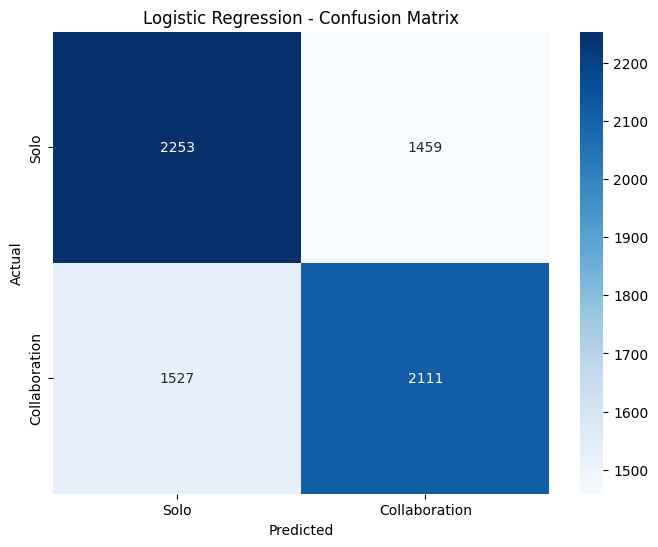

In [ ]:
# Confusion Matrix
cm_lr = confusion_matrix(y_test_lr, y_test_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Solo', 'Collaboration'],
            yticklabels=['Solo', 'Collaboration'])
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
numerical_features = X_logistic_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [ ]:
# Pipeline with preprocessing and regularization
preprocessor = ColumnTransformer([
    ('num_scaler', StandardScaler(), numerical_features),
    ('poly_features', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), numerical_features),
], remainder='passthrough')

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])


In [ ]:
# Pipeline with preprocessing and regularization
preprocessor = ColumnTransformer([
    ('num_scaler', StandardScaler(), numerical_features),
    ('poly_features', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False), numerical_features),
], remainder='passthrough')

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])


In [ ]:
# Cell: Simplified Hyperparameter Tuning (after X_train_lr, y_train_lr are defined)

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

#Logistic pipeline (no polynomial features)
lr_simple = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear', max_iter=500))
])

# 2. Narrow hyperparameter distribution
param_dist_simple = {
    'clf__C': [0.1, 1, 10],        # three values only
    'clf__penalty': ['l1', 'l2']   # both L1 and L2
}

# 3. RandomizedSearch with minimal iterations and folds
search_simple = RandomizedSearchCV(
    estimator=lr_simple,
    param_distributions=param_dist_simple,
    n_iter=3,      # only 3 combinations
    scoring='roc_auc',
    cv=2,          # 2-fold CV
    n_jobs=1,      # single core to reduce overhead
    verbose=1,
    random_state=42
)

# 4. Fit and report
search_simple.fit(X_train_lr, y_train_lr)
print("Best params:", search_simple.best_params_)
print(f"Best CV AUC: {search_simple.best_score_:.4f}")


Fitting 2 folds for each of 3 candidates, totalling 6 fits
Best params: {'clf__penalty': 'l2', 'clf__C': 10}
Best CV AUC: 0.6285


In [ ]:
best_lr_model = search_simple.best_estimator_
y_test_pred_best_lr      = best_lr_model.predict(X_test_lr)
y_test_pred_prob_best_lr = best_lr_model.predict_proba(X_test_lr)[:, 1]

test_accuracy_best_lr = accuracy_score(y_test_lr, y_test_pred_best_lr)
test_auc_best_lr      = roc_auc_score(y_test_lr, y_test_pred_prob_best_lr)

print("Optimized Logistic Regression Performance:")
print(f" Test Accuracy : {test_accuracy_best_lr:.4f}")
print(f" Test AUC-ROC  : {test_auc_best_lr:.4f}")

Optimized Logistic Regression Performance:
 Test Accuracy : 0.5939
 Test AUC-ROC  : 0.6319


**RANDOM FOREST**
 COLLABORATION PREDICTION

In [ ]:
exclude_cols_rf = ["track_id", "artists", "album_name", "track_name", "track_genre", "collaboration"]
X_rf = df_songs_tree.drop(columns=exclude_cols_rf)
y_rf = df_songs_tree["collaboration"]
X_rf_encoded = pd.get_dummies(X_rf, drop_first=True)
X_rf_encoded = X_rf_encoded.apply(pd.to_numeric, errors="coerce").fillna(0)


In [ ]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf_encoded, y_rf, test_size=0.2, random_state=42
)

In [ ]:
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

RandomForestClassifier(random_state=42)

Top 15 Most Important Features:
             feature  importance
2       danceability    0.094905
6       acousticness    0.092008
4           loudness    0.089964
5        speechiness    0.089688
9            valence    0.088214
11     duration_mins    0.084140
3             energy    0.082797
10             tempo    0.082286
0         popularity    0.074270
8           liveness    0.072985
7   instrumentalness    0.059532
23        mode_Minor    0.009602
14             key_C    0.007080
21             key_G    0.006969
15         key_C♯/D♭    0.006944


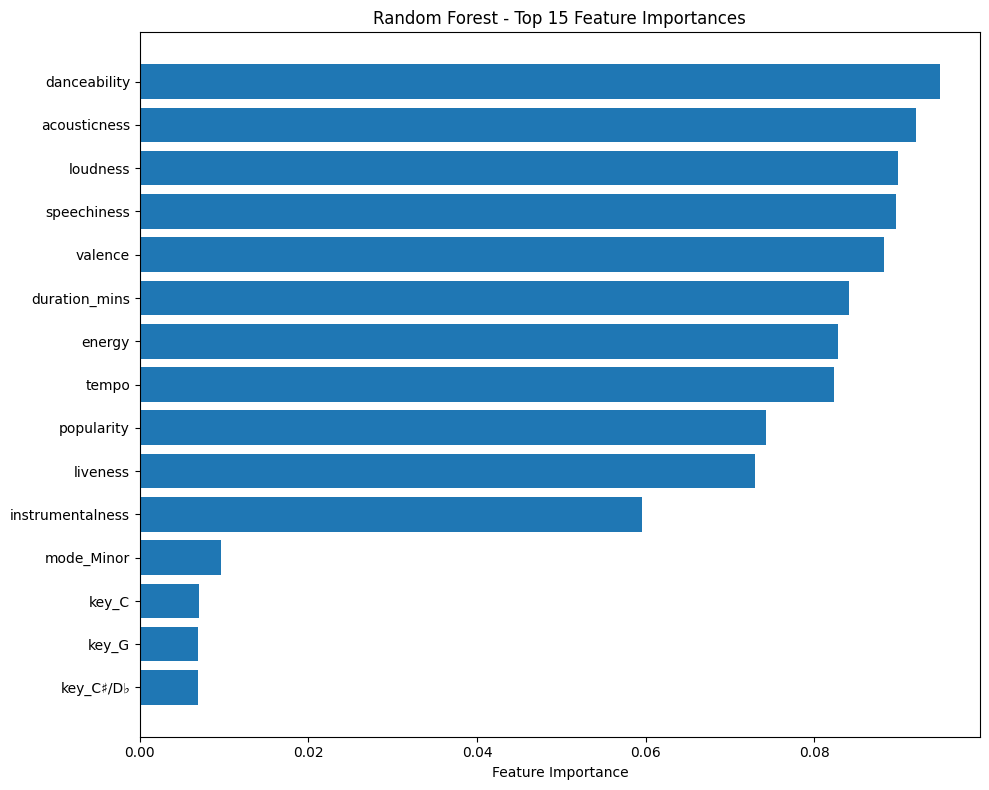

In [ ]:
feature_importance = pd.DataFrame({
    'feature': X_rf_encoded.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
print(feature_importance.head(15))


# Visualize feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest - Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Model evaluation
y_train_pred_rf = rf_model.predict(X_train_rf)
y_test_pred_rf = rf_model.predict(X_test_rf)
y_train_pred_prob_rf = rf_model.predict_proba(X_train_rf)[:, 1]
y_test_pred_prob_rf = rf_model.predict_proba(X_test_rf)[:, 1]

train_accuracy_rf = accuracy_score(y_train_rf, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test_rf, y_test_pred_rf)
train_auc_rf = roc_auc_score(y_train_rf, y_train_pred_prob_rf)
test_auc_rf = roc_auc_score(y_test_rf, y_test_pred_prob_rf)

print(f"\nRandom Forest Performance:")
print(f"Train Accuracy: {train_accuracy_rf:.4f}")
print(f"Test Accuracy: {test_accuracy_rf:.4f}")
print(f"Train AUC-ROC: {train_auc_rf:.4f}")
print(f"Test AUC-ROC: {test_auc_rf:.4f}")


Random Forest Performance:
Train Accuracy: 1.0000
Test Accuracy: 0.8620
Train AUC-ROC: 1.0000
Test AUC-ROC: 0.8994


In [ ]:
# Cross-validation scores
cv_scores_rf = cross_val_score(rf_model, X_train_rf, y_train_rf, cv=5, scoring='roc_auc')
cv_accuracy_rf = cross_val_score(rf_model, X_train_rf, y_train_rf, cv=5, scoring='accuracy')

print(f"Cross-Validation AUC: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")
print(f"Cross-Validation Accuracy: {cv_accuracy_rf.mean():.4f} (+/- {cv_accuracy_rf.std() * 2:.4f})")


Cross-Validation AUC: 0.8854 (+/- 0.0043)
Cross-Validation Accuracy: 0.8489 (+/- 0.0037)


In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}


In [ ]:
#Faster Random Forest Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

#Narrower parameter space
param_dist_rf_fast = {
    'n_estimators': [100, 150],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

#Using fewer iterations and CV folds
rf_fast_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_rf_fast,
    n_iter=8,        # only 8 combinations
    cv=3,            # 3-fold CV (instead of 5)
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

#Fitting and report
rf_fast_search.fit(X_train_rf, y_train_rf)
print("Best RF Params (fast):", rf_fast_search.best_params_)
print(f"Best CV AUC (fast): {rf_fast_search.best_score_:.4f}")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best RF Params (fast): {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Best CV AUC (fast): 0.8765


In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble    import RandomForestClassifier
from sklearn.metrics     import accuracy_score, roc_auc_score

#Only tuning non-n_estimators params
param_dist = {
    'max_depth':         [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf':  [1, 2],
    'max_features':      ['sqrt', 'log2']
}

#Halving search across n_estimators as the “resource”
halving = HalvingRandomSearchCV(
    estimator=RandomForestClassifier(bootstrap=True, n_jobs=-1, random_state=42),
    param_distributions=param_dist,
    factor=2,
    resource='n_estimators',
    min_resources=50,    # start each candidate with 50 trees
    max_resources=150,   # end with 150 trees
    cv=3,
    scoring='roc_auc',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

halving.fit(X_train_rf, y_train_rf)
best_rf = halving.best_estimator_

#Evaluate on test
y_pred = best_rf.predict(X_test_rf)
y_prob = best_rf.predict_proba(X_test_rf)[:, 1]
print("🔍 Best params:", halving.best_params_)
print(f"CV AUC (halving): {halving.best_score_:.4f}")
print("Test Acc:",    accuracy_score(y_test_rf, y_pred))
print("Test AUC:",    roc_auc_score(y_test_rf, y_prob))


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 50
max_resources_: 150
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 3
n_resources: 50
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 1
n_candidates: 2
n_resources: 100
Fitting 3 folds for each of 2 candidates, totalling 6 fits
🔍 Best params: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'n_estimators': 100}
CV AUC (halving): 0.8741
Test Acc: 0.8620491513437057
Test AUC: 0.8993712164333251


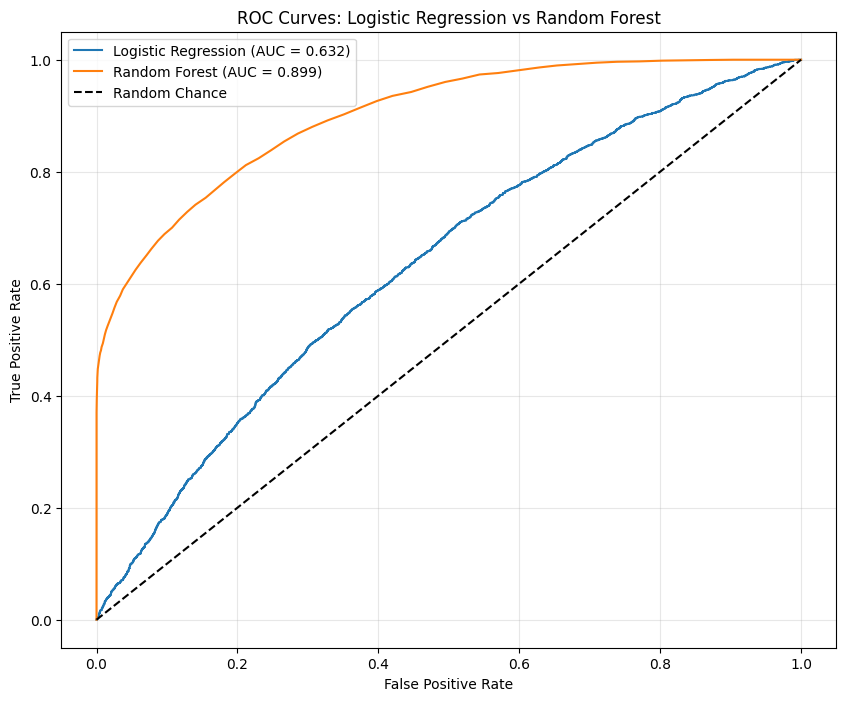

In [ ]:
# ROC Curve Comparison
plt.figure(figsize=(10, 8))

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test_lr, y_test_pred_prob_best_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {test_auc_best_lr:.3f})')

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test_rf, y_test_pred_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {test_auc_rf:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Logistic Regression vs Random Forest')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**K-NEAREST NEIGHBORS**
 SONG RECOMMENDATION SYSTEM

In [ ]:
exclude_cols_knn = ["track_id", "album_name", "collaboration", "high_pop", "explicit"]
metadata_cols = ["artists", "track_name", "track_genre"]

df_knn = df_songs.drop(columns=exclude_cols_knn)
numerical_features_knn = df_knn.drop(columns=metadata_cols)

(72800, 14)


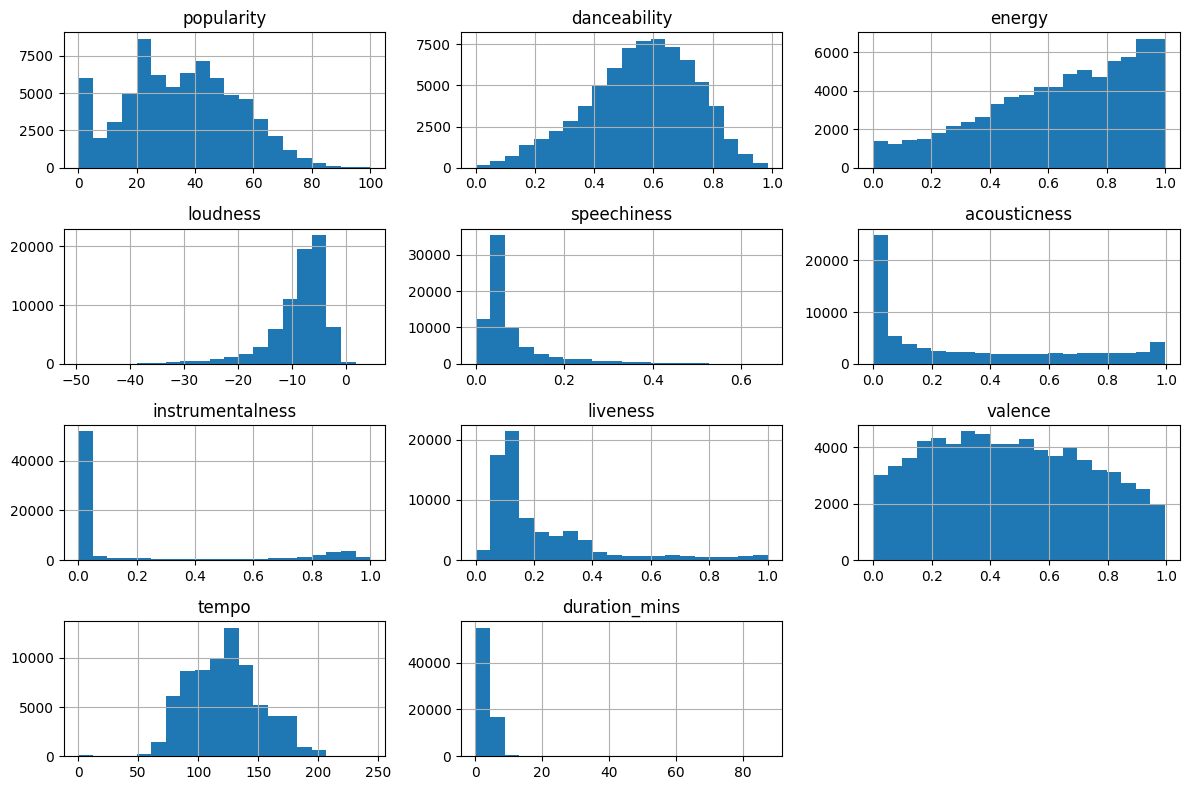

In [ ]:
import matplotlib.pyplot as plt
print(numerical_features_knn.shape)
numerical_features_knn.head()

numerical_features_knn.hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()





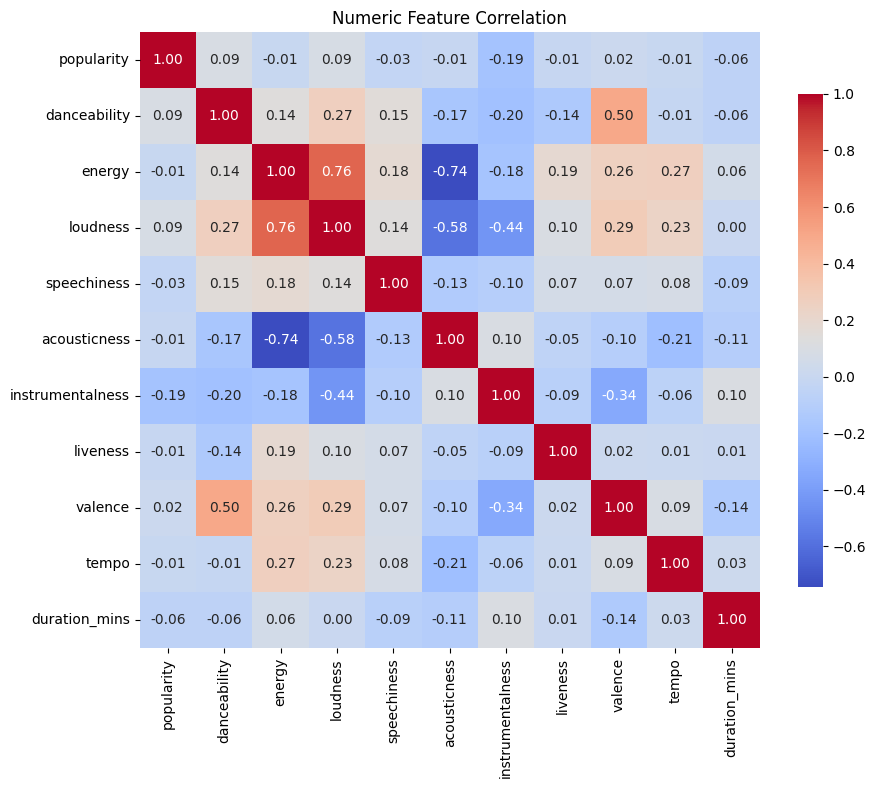

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
num_only = numerical_features_knn.select_dtypes(include=['int64','float64'])

#Compute correlation matrix
corr_matrix = num_only.corr()
#Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True, fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'shrink': .8}
)
plt.title("Numeric Feature Correlation")
plt.show()


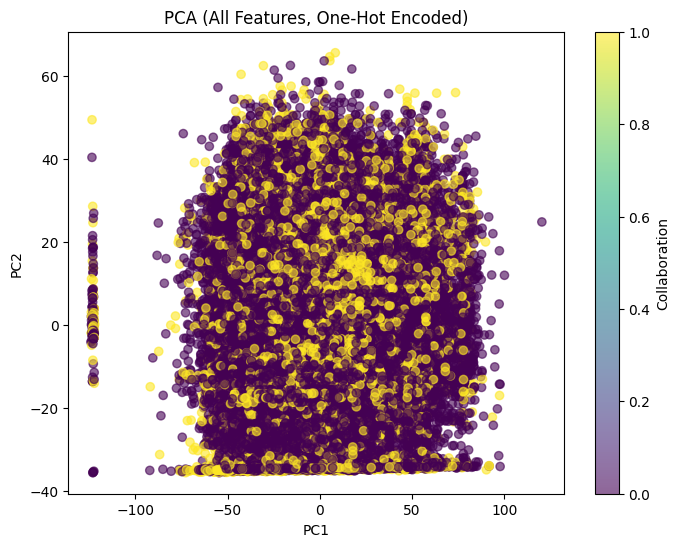

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# 1) One-hot encode any leftover categorical columns
encoded = pd.get_dummies(numerical_features_knn, drop_first=True)

# 2) Fit PCA on the expanded matrix
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(encoded)

# 3) Plot with the same coloring
plt.figure(figsize=(8,6))
plt.scatter(
    coords[:, 0],
    coords[:, 1],
    c=df_songs['collaboration'].map({False: 0, True: 1}),
    alpha=0.6
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (All Features, One-Hot Encoded)")
plt.colorbar(label="Collaboration")
plt.show()
